# Import Dataset

In [444]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer
)
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import PredefinedSplit



#Importing the functions created in main.py
from Preprocessing_functions import *
import importlib
imported_module = importlib.import_module("Preprocessing_functions")
importlib.reload(imported_module)

<module 'Preprocessing_functions' from 'c:\\Users\\timst\\OneDrive\\Desktop\\NOVA IMS\\Semester 1\\MachineLearning\\Project\\ML_Group36\\src\\Preprocessing_functions.py'>

In [445]:
train_data = pd.read_csv('train_data.csv', index_col='Claim Identifier')
test_data = pd.read_csv('test_data.csv', index_col='Claim Identifier')

C:\Users\timst\AppData\Local\Temp\ipykernel_42444\3470921380.py:1: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv('train_data.csv', index_col='Claim Identifier')


# Preprocessing

In [446]:
train_data = train_data[~(train_data.drop(columns=['Assembly Date']).isna().all(axis=1) & train_data['Assembly Date'].notna())]

In [447]:
X_train = train_data.drop(columns=['Claim Injury Type', 'WCB Decision', 'Agreement Reached'])
y_train = train_data['Claim Injury Type']


X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42,stratify=y_train)

Column Selection

In [448]:
CODE_COLUMNS = ['Industry Code', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code']

DESCRIPTION_COLUMNS = ['WCIO Cause of Injury Description','WCIO Nature of Injury Description','WCIO Part Of Body Description','Industry Code Description']

BOOLEAN_COLUMNS = ['Alternative Dispute Resolution', 'Attorney/Representative','COVID-19 Indicator']

date_order = ['Accident Date', 'C-2 Date','C-3 Date','Assembly Date', 'First Hearing Date']


In [449]:
numerical_columns = [
    'Accident Date', 
    'Age at Injury', 
    'Assembly Date', 
    'Average Weekly Wage', 
    'Birth Year', 
    'C-2 Date', 
    'C-3 Date', 
    'First Hearing Date', 
    'IME-4 Count', 
]

outliers_columns = [
    'Accident Date', 
    'Age at Injury', 
    'Assembly Date', 
    'Average Weekly Wage', 
    'Birth Year',
    'IME-4 Count', 
]

categorical_features = ['Alternative Dispute Resolution',
 'Attorney/Representative',
 'Carrier Name',
 'Carrier Type',
 'County of Injury',
 'COVID-19 Indicator',
 'District Name',
 'Gender',
 'Industry Code',
 'Medical Fee Region',
 'WCIO Cause of Injury Code',
 'WCIO Nature of Injury Code',
 'WCIO Part Of Body Code',
 'Zip Code']

col_minmax = ['Age at Injury',
               'Birth Year', 
               'Number of Dependents']

col_standart = ['Accident Date',
                'Assembly Date',
                'Average Weekly Wage',
                ]

columns_to_drop = ['C-2 Date', 'C-3 Date', 'First Hearing Date']

low_cardinality_cols = [col for col in categorical_features if X_train[col].nunique() < 15]
high_cardinality_cols = [col for col in categorical_features if X_train[col].nunique() > 15]

New Feature Creation

In [450]:
binning_columns = ['Age at Injury', 'Age at Injury', 'Birth Year', 'Average Weekly Wage', 'IME-4 Count']
date_columns = ['Accident Date', 'Assembly Date']

def create_groupingFeatures(X_train, X_val):
    X_train, X_val= newFeature_binnedGroups(X_train, X_val, binning_columns, 6)
    # Add all names of the binning_column + 'Group' to the list of categorical_features
    for col in binning_columns:
        categorical_features.append(col + ' Group')
        X_train[f'{col} Group'].astype(str)
        X_val[f'{col} Group'].astype(str)

    X_train, X_val = newFeature_month(X_train, X_val, date_columns)
    # Add all names of the date_columns + 'Month' to the list of categorical_features
    for col in date_columns:
        categorical_features.append(col + ' Month')
        X_train[f'{col} Month'].astype(str)
        X_val[f'{col} Month'].astype(str)



    X_train, X_val = newFeature_daysBetween(X_train, X_val, 'Accident Date', 'Assembly Date')
    numerical_columns.append('Days Between Accident Date and Assembly Date')
    
    return X_train, X_val

Preprocessing Functions

In [451]:
from sklearn.preprocessing import RobustScaler

def scaling_robust(X_train, X_val, columns):
    """
    Applies RobustScaler to the specified columns of the training and validation data.
    
    Parameters:
    - X_train: Training dataset as a DataFrame.
    - X_val: Validation dataset as a DataFrame.
    - columns: List of column names to be scaled.
    
    Returns:
    - Scaled X_train and X_val DataFrames.
    """
    scaler = RobustScaler()

    # Apply RobustScaler to the specified columns
    X_train[columns] = scaler.fit_transform(X_train[columns])
    X_val[columns] = scaler.transform(X_val[columns])
    
    return X_train, X_val


In [452]:
def type_conversion_categorical(X_train, X_val, categorical_features):
    X_train[categorical_features] = X_train[categorical_features].astype(str)
    X_val[categorical_features] = X_val[categorical_features].astype(str)
    return X_train, X_val

In [453]:
def unwanted_columns(X_train, X_val, columns):
    X_train = X_train.drop(columns, axis=1)
    X_val = X_val.drop(columns, axis=1)
    return X_train, X_val

In [454]:
X_train["IME-4 Count"].fillna(0, inplace=True)
X_val["IME-4 Count"].fillna(0, inplace=True)

C:\Users\timst\AppData\Local\Temp\ipykernel_42444\939417667.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train["IME-4 Count"].fillna(0, inplace=True)
C:\Users\timst\AppData\Local\Temp\ipykernel_42444\939417667.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example

In [455]:
def winsorize_outliers(X_train, X_val, columns):
    """
    Winsorizes outliers in the specified columns for X_train and X_val.
    The bounds are calculated based on the X_train data.
    """
    for column in columns:
        # Calculate bounds based on X_train
        q1 = X_train[column].quantile(0.25)
        q3 = X_train[column].quantile(0.75)
        iqr = q3 - q1

        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Winsorize the column in X_train
        X_train[column] = X_train[column].apply(
            lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x)
        )

        # Winsorize the column in X_val using the same bounds
        X_val[column] = X_val[column].apply(
            lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x)
        )

    return X_train, X_val

In [456]:
def preprocessing_scaling_encoding_dum(X_train, X_val):
    X_train, X_val = type_conversion_categorical(X_train, X_val, categorical_features)
    X_train, X_val = drop_description_columns(X_train, X_val)
    X_train, X_val = convert_to_timestamp(X_train, X_val, date_order)
    X_train, X_val = convert_to_bool(X_train, X_val, col_names=BOOLEAN_COLUMNS)
    X_train, X_val = impute_mean_numerical(X_train, X_val, numerical_columns)
    X_train, X_val = fill_missing_with_mode(X_train, X_val)
    X_train, X_val = feature_creation_has_Cdate(X_train, X_val)
    X_train, X_val = unwanted_columns(X_train, X_val, columns_to_drop)
    X_train, X_val = winsorize_outliers(X_train, X_val, outliers_columns)
    X_train, X_val = scaling_minmax(X_train, X_val, col_minmax)
    X_train, X_val = scaling_standard(X_train, X_val, col_standart)
    X_train, X_val = encoding_onehot(X_train, X_val, low_cardinality_cols)
    X_train, X_val = encoding_frequency1(X_train, X_val, high_cardinality_cols)
    return X_train, X_val

In [457]:
def preprocessing_newFeatures_dum(X_train, X_val):
    X_train, X_val = type_conversion_categorical(X_train, X_val, categorical_features)
    X_train, X_val = drop_description_columns(X_train, X_val)
    X_train, X_val = convert_to_timestamp(X_train, X_val, date_order)
    X_train, X_val = convert_to_bool(X_train, X_val, col_names=BOOLEAN_COLUMNS)
    X_train, X_val = impute_mean_numerical(X_train, X_val, numerical_columns)
    X_train, X_val = fill_missing_with_mode(X_train, X_val)
    X_train, X_val = feature_creation_has_Cdate(X_train, X_val)
    X_train, X_val = unwanted_columns(X_train, X_val, columns_to_drop)
    X_train, X_val = convert_to_datetime(X_train, X_val, date_columns)
    X_train, X_val= create_groupingFeatures(X_train, X_val)
    #X_train, X_val = type_conversion_categorical(X_train, X_val, categorical_features)
    X_train, X_val = convert_to_timestamp(X_train, X_val, date_columns)
    X_train, X_val = winsorize_outliers(X_train, X_val, outliers_columns)
    X_train, X_val = scaling_robust(X_train, X_val, binning_columns)
    X_train, X_val = scaling_robust(X_train, X_val, date_columns)

    # Ensure categorical_features contains unique column names
    valid_categorical_features = list(set(categorical_features))

    # Verify all columns in categorical_features exist in X_train
    valid_categorical_features = [col for col in valid_categorical_features if col in X_train.columns]
    print(f'Valid categorical features: {valid_categorical_features}')


    low_cardinality_cols = [col for col in valid_categorical_features if X_train[col].nunique() < 15]
    high_cardinality_cols = [col for col in valid_categorical_features if X_train[col].nunique() > 15]

    X_train, X_val = encoding_onehot(X_train, X_val, low_cardinality_cols)
    X_train, X_val = encoding_frequency1(X_train, X_val, high_cardinality_cols)
    return X_train, X_val

In [458]:
#X_train, X_val = preprocessing_scaling_encoding_dum(X_train, X_val)

In [459]:
X_train, X_val = preprocessing_newFeatures_dum(X_train, X_val)

c:\Users\timst\OneDrive\Desktop\NOVA IMS\Semester 1\MachineLearning\Project\ML_Group36\src\Preprocessing_functions.py:327: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[col].fillna(mean_value, inplace=True)
c:\Users\timst\OneDrive\Desktop\NOVA IMS\Semester 1\MachineLearning\Project\ML_Group36\src\Preprocessing_functions.py:328: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will

Valid categorical features: ['Age at Injury Group', 'Accident Date Month', 'Gender', 'Zip Code', 'IME-4 Count Group', 'WCIO Nature of Injury Code', 'County of Injury', 'Assembly Date Month', 'District Name', 'WCIO Part Of Body Code', 'Industry Code', 'Attorney/Representative', 'COVID-19 Indicator', 'Carrier Name', 'Birth Year Group', 'Medical Fee Region', 'Carrier Type', 'Average Weekly Wage Group', 'WCIO Cause of Injury Code', 'Alternative Dispute Resolution']


In [460]:
y_train, y_val = encoding_label(y_train, y_val)

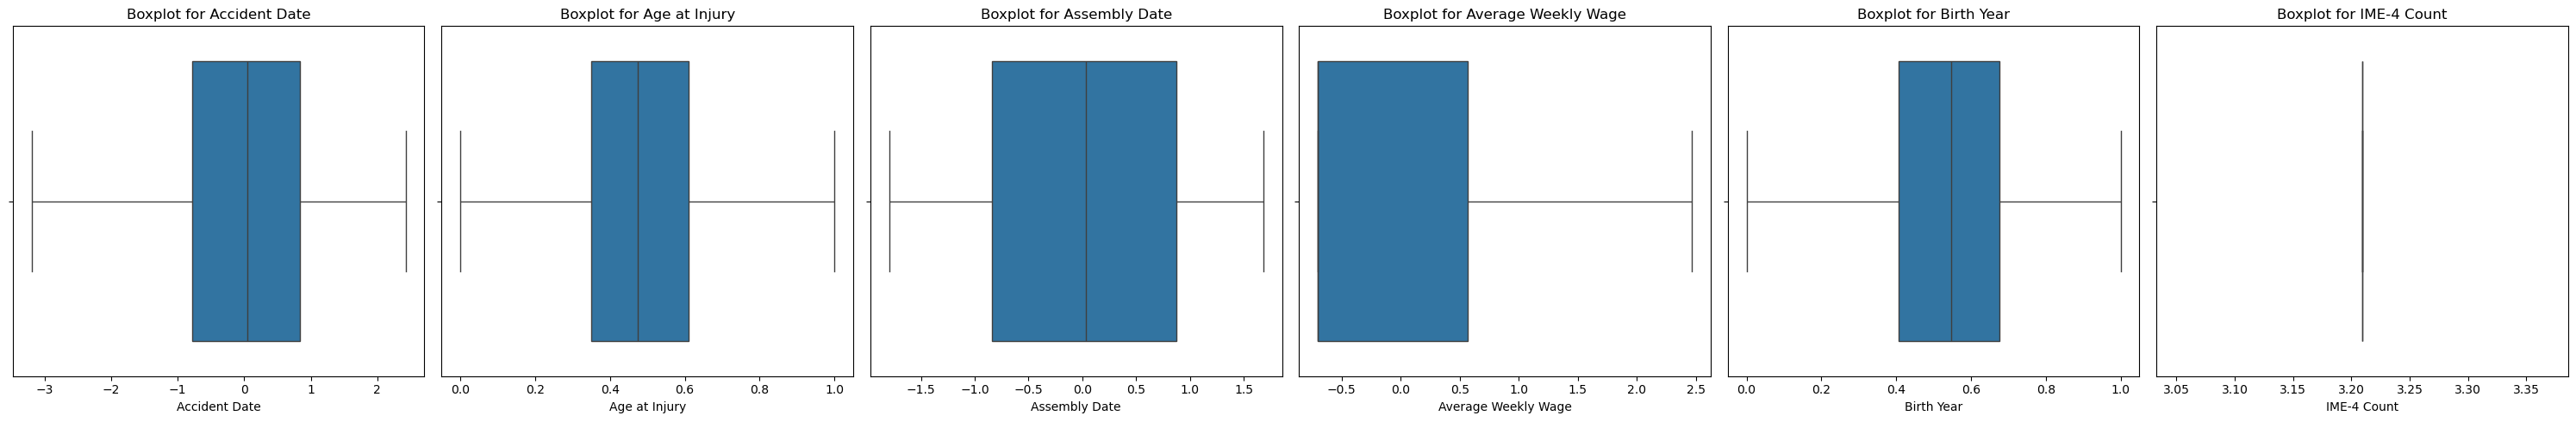

In [59]:
def plot_boxplots(df, columns):
    """
    Plots box plots for a list of columns in the given DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    columns (list): The list of column names to plot.

    Returns:
    None
    """
    num_columns = len(columns)
    fig, axes = plt.subplots(1, num_columns, figsize=(5 * num_columns, 5))

    # Ensure axes is iterable even for one column
    if num_columns == 1:
        axes = [axes]

    for ax, column in zip(axes, columns):
        sns.boxplot(data=df, x=column, ax=ax)
        ax.set_title(f'Boxplot for {column}')

    plt.tight_layout()
    plt.show()

# Example usage
plot_boxplots(X_train, outliers_columns)

Perform RFE outside SKF.

We are aware that this introduces data leakage as features get selected based from unseen data in the SKF.

Reason: Computational time constraints.

Reasoning: We keep the data leakage "consistent" across all models, meaning same split, same preprocessing resulting in same feature ranking. Therefore we believe that the data leakage impact cancels out between the models and the decision for out final model is unbiased.

The prediction on the final test set will be without data leakage.

#### RFECV Baseline Preprocessing

In [60]:
# f1_macro_scorer = make_scorer(f1_score, average='macro')

# X_train_selected, selected_features, feature_ranking, optimal_num_features = feature_selection_rfecv(X_train, y_train, LogisticRegression(max_iter=1000), cv_folds=5, scoring=f1_macro_scorer)

In [61]:
#feature_ranking

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Feature</th>
      <th>Ranking</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>24</th>
      <td>COVID-19 Indicator_True</td>
      <td>1</td>
    </tr>
    <tr>
      <th>47</th>
      <td>WCIO Part Of Body Code</td>
      <td>1</td>
    </tr>
    <tr>
      <th>10</th>
      <td>Alternative Dispute Resolution_False</td>
      <td>1</td>
    </tr>
    <tr>
      <th>43</th>
      <td>County of Injury</td>
      <td>1</td>
    </tr>
    <tr>
      <th>44</th>
      <td>Industry Code</td>
      <td>1</td>
    </tr>
    <tr>
      <th>45</th>
      <td>WCIO Cause of Injury Code</td>
      <td>1</td>
    </tr>
    <tr>
      <th>13</th>
      <td>Attorney/Representative_False</td>
      <td>1</td>
    </tr>
    <tr>
      <th>3</th>
      <td>Average Weekly Wage</td>
      <td>1</td>
    </tr>
    <tr>
      <th>1</th>
      <td>Age at Injury</td>
      <td>1</td>
    </tr>
    <tr>
      <th>46</th>
      <td>WCIO Nature of Injury Code</td>
      <td>1</td>
    </tr>
    <tr>
      <th>42</th>
      <td>Carrier Name</td>
      <td>2</td>
    </tr>
    <tr>
      <th>16</th>
      <td>Carrier Type_2A. SIF</td>
      <td>3</td>
    </tr>
    <tr>
      <th>22</th>
      <td>Carrier Type_UNKNOWN</td>
      <td>4</td>
    </tr>
    <tr>
      <th>23</th>
      <td>COVID-19 Indicator_False</td>
      <td>5</td>
    </tr>
    <tr>
      <th>11</th>
      <td>Alternative Dispute Resolution_True</td>
      <td>6</td>
    </tr>
    <tr>
      <th>5</th>
      <td>IME-4 Count</td>
      <td>7</td>
    </tr>
    <tr>
      <th>14</th>
      <td>Attorney/Representative_True</td>
      <td>8</td>
    </tr>
    <tr>
      <th>4</th>
      <td>Birth Year</td>
      <td>9</td>
    </tr>
    <tr>
      <th>17</th>
      <td>Carrier Type_3A. SELF PUBLIC</td>
      <td>10</td>
    </tr>
    <tr>
      <th>31</th>
      <td>District Name_STATEWIDE</td>
      <td>11</td>
    </tr>
    <tr>
      <th>29</th>
      <td>District Name_NYC</td>
      <td>12</td>
    </tr>
    <tr>
      <th>28</th>
      <td>District Name_HAUPPAUGE</td>
      <td>13</td>
    </tr>
    <tr>
      <th>33</th>
      <td>Gender_F</td>
      <td>14</td>
    </tr>
    <tr>
      <th>21</th>
      <td>Carrier Type_5D. SPECIAL FUND - UNKNOWN</td>
      <td>15</td>
    </tr>
    <tr>
      <th>36</th>
      <td>Gender_X</td>
      <td>16</td>
    </tr>
    <tr>
      <th>18</th>
      <td>Carrier Type_4A. SELF PRIVATE</td>
      <td>17</td>
    </tr>
    <tr>
      <th>15</th>
      <td>Carrier Type_1A. PRIVATE</td>
      <td>18</td>
    </tr>
    <tr>
      <th>2</th>
      <td>Assembly Date</td>
      <td>19</td>
    </tr>
    <tr>
      <th>0</th>
      <td>Accident Date</td>
      <td>20</td>
    </tr>
    <tr>
      <th>30</th>
      <td>District Name_ROCHESTER</td>
      <td>21</td>
    </tr>
    <tr>
      <th>27</th>
      <td>District Name_BUFFALO</td>
      <td>22</td>
    </tr>
    <tr>
      <th>34</th>
      <td>Gender_M</td>
      <td>23</td>
    </tr>
    <tr>
      <th>9</th>
      <td>Has First Hearing Date</td>
      <td>24</td>
    </tr>
    <tr>
      <th>38</th>
      <td>Medical Fee Region_II</td>
      <td>25</td>
    </tr>
    <tr>
      <th>26</th>
      <td>District Name_BINGHAMTON</td>
      <td>26</td>
    </tr>
    <tr>
      <th>32</th>
      <td>District Name_SYRACUSE</td>
      <td>27</td>
    </tr>
    <tr>
      <th>8</th>
      <td>Has C-2 Date</td>
      <td>28</td>
    </tr>
    <tr>
      <th>7</th>
      <td>Has C-3 Date</td>
      <td>29</td>
    </tr>
    <tr>
      <th>41</th>
      <td>Medical Fee Region_UK</td>
      <td>30</td>
    </tr>
    <tr>
      <th>35</th>
      <td>Gender_U</td>
      <td>31</td>
    </tr>
    <tr>
      <th>39</th>
      <td>Medical Fee Region_III</td>
      <td>32</td>
    </tr>
    <tr>
      <th>40</th>
      <td>Medical Fee Region_IV</td>
      <td>33</td>
    </tr>
    <tr>
      <th>19</th>
      <td>Carrier Type_5A. SPECIAL FUND - CONS. COMM. (S...</td>
      <td>34</td>
    </tr>
    <tr>
      <th>48</th>
      <td>Zip Code</td>
      <td>35</td>
    </tr>
    <tr>
      <th>25</th>
      <td>District Name_ALBANY</td>
      <td>36</td>
    </tr>
    <tr>
      <th>20</th>
      <td>Carrier Type_5C. SPECIAL FUND - POI CARRIER WC...</td>
      <td>37</td>
    </tr>
    <tr>
      <th>6</th>
      <td>Number of Dependents</td>
      <td>38</td>
    </tr>
    <tr>
      <th>37</th>
      <td>Medical Fee Region_I</td>
      <td>39</td>
    </tr>
    <tr>
      <th>12</th>
      <td>Alternative Dispute Resolution_nan</td>
      <td>40</td>
    </tr>
  </tbody>
</table>
</div>

In [62]:
features = [
    "COVID-19 Indicator_True",
    "WCIO Part Of Body Code",
    "Alternative Dispute Resolution_False",
    "County of Injury",
    "Industry Code",
    "WCIO Cause of Injury Code",
    "Attorney/Representative_False",
    "Average Weekly Wage",
    "Age at Injury",
    "WCIO Nature of Injury Code",
    "Carrier Name",
    "Carrier Type_2A. SIF",
    "Carrier Type_UNKNOWN",
    "COVID-19 Indicator_False",
    "Alternative Dispute Resolution_True",
    "IME-4 Count",
    "Attorney/Representative_True",
    "Birth Year",
    "Carrier Type_3A. SELF PUBLIC",
    "District Name_STATEWIDE",
    "District Name_NYC",
    "District Name_HAUPPAUGE",
    "Gender_F",
    "Carrier Type_5D. SPECIAL FUND - UNKNOWN",
    "Gender_X",
    "Carrier Type_4A. SELF PRIVATE",
    "Carrier Type_1A. PRIVATE",
    "Assembly Date",
    "Accident Date",
    "District Name_ROCHESTER",
    "District Name_BUFFALO",
    "Gender_M",
    "Has First Hearing Date",
    "Medical Fee Region_II",
    "District Name_BINGHAMTON",
    "District Name_SYRACUSE",
    "Has C-2 Date",
    "Has C-3 Date",
    "Medical Fee Region_UK",
    "Gender_U",
    "Medical Fee Region_III",
    "Medical Fee Region_IV",
    "Carrier Type_5A. SPECIAL FUND - CONS. COMM.",
    "Zip Code",
    "District Name_ALBANY",
    "Carrier Type_5C. SPECIAL FUND - POI CARRIER WC...",
    "Number of Dependents",
    "Medical Fee Region_I",
    "Alternative Dispute Resolution_nan"
]

In [63]:
selected_features = ['COVID-19 Indicator_True',
 'WCIO Part Of Body Code',
 'Alternative Dispute Resolution_False',
 'County of Injury',
 'Industry Code',
 'WCIO Cause of Injury Code',
 'Attorney/Representative_False',
 'Average Weekly Wage',
 'Age at Injury',
 'WCIO Nature of Injury Code']

['COVID-19 Indicator_True',
 'WCIO Part Of Body Code',
 'Alternative Dispute Resolution_False',
 'County of Injury',
 'Industry Code',
 'WCIO Cause of Injury Code',
 'Attorney/Representative_False',
 'Average Weekly Wage',
 'Age at Injury',
 'WCIO Nature of Injury Code']

In [64]:
best_10_features = ['COVID-19 Indicator_True', 'WCIO Part Of Body Code', 'Alternative Dispute Resolution_False', 
 'County of Injury', 'Industry Code', 'WCIO Cause of Injury Code', 
 'Attorney/Representative_False', 'Average Weekly Wage', 'Age at Injury', 
 'WCIO Nature of Injury Code']

In [65]:
best_20_features = ['COVID-19 Indicator_True', 'WCIO Part Of Body Code', 'Alternative Dispute Resolution_False', 
 'County of Injury', 'Industry Code', 'WCIO Cause of Injury Code', 
 'Attorney/Representative_False', 'Average Weekly Wage', 'Age at Injury', 
 'WCIO Nature of Injury Code', 'Carrier Name', 'Carrier Type_2A. SIF', 
 'Carrier Type_UNKNOWN', 'COVID-19 Indicator_False', 
 'Alternative Dispute Resolution_True', 'IME-4 Count', 
 'Attorney/Representative_True', 'Birth Year', 
 'Carrier Type_3A. SELF PUBLIC', 'District Name_STATEWIDE', 
 'District Name_NYC', 'District Name_HAUPPAUGE', 'Gender_F']

# Model Training

## 1. Baseline Model Run


__Preprocessing:__

preprocessing_scaling_encoding_dum()


__Selected features:__ 

['COVID-19 Indicator_True','WCIO Part Of Body Code', 'Alternative Dispute Resolution_False', 'County of Injury''Industry Code', 'WCIO Cause of Injury Code', 'Attorney/Representative_False','Average Weekly Wage','Age at Injury','WCIO Nature of Injury Code']

__Model:__

MLPClassifier(
        activation='relu',
        solver='adam',
        learning_rate_init=0.01,
        max_iter=1000,  # Increase if needed
        random_state=42,
        hidden_layer_sizes = (int(0.75 * len(selected_features)), int(0.5 * len(selected_features))) # Adjust the number of neurons in the hidden layers according to the number of selected features
    )

In [66]:
# X, y = X.sample(n=50000, random_state=42), y.loc[X.sample(n=50000, random_state=42).index]

In [67]:
model = MLPClassifier(
        activation='relu',
        solver='adam',
        learning_rate_init=0.01,
        max_iter=1000,  # Increase if needed
        random_state=42,
        hidden_layer_sizes = (int(0.75 * len(selected_features)), int(0.5 * len(selected_features))) # Adjust the number of neurons in the hidden layers according to the number of selected features
    )

model_iterincrease =  model = MLPClassifier(
        activation='relu',
        solver='adam',
        learning_rate_init=0.01,
        max_iter=2000,  # Increase if needed
        random_state=42
    )

df = pd.DataFrame(columns = ['Train','Val', 'Iterations'], index = ['1000 iter', '2000 iter'])


In [68]:
def evaluate_nn_with_skf(model, X, y, n_splits=10):
    """
    Evaluate a Neural Network model using StratifiedKFold cross-validation.

    Parameters:
    - model: The neural network model (e.g., an instance of MLPClassifier).
    - X: Preprocessed feature matrix.
    - y: Target variable (encoded as required for the model).
    - n_splits: Number of folds for StratifiedKFold (default: 10).

    Returns:
    - avg_macro_f1: Average macro F1-score across folds.
    - avg_iter: Average number of iterations across folds.
    """
    # Initialize StratifiedKFold
    skf = StratifiedKFold(n_splits=n_splits, random_state=42, shuffle=True)

    # Metrics and iteration tracking
    macro_f1_scores = []
    n_iter_list = []

    for train_index, val_index in skf.split(X, y):
        # Get train and validation splits
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Train the model
        model.fit(X_train[selected_features], y_train)

        # Predict on validation set
        y_pred_val = model.predict(X_val[selected_features])

        # Calculate macro F1-score
        macro_f1 = f1_score(y_val, y_pred_val, average='macro')
        macro_f1_scores.append(macro_f1)

        # Record the number of iterations
        n_iter_list.append(model.n_iter_)

    # Compute average and standard deviation of metrics
    avg_macro_f1 = f"{np.mean(macro_f1_scores):.3f} +/- {np.std(macro_f1_scores):.3f}"
    avg_iter = f"{np.mean(n_iter_list):.1f} +/- {np.std(n_iter_list):.1f}"

    return avg_macro_f1, avg_iter


In [69]:
# avg_macro_f1, avg_iter = evaluate_nn_with_skf(model, X[selected_features], y, n_splits=10)

Results Baseline Run:

avg_macro_f1 = 0.317 +/- 0.009

avg_iter = 39.4 +/- 8.5


In [70]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, ParameterGrid
import os

def grid_search_nn_with_checkpoints(model, X, y, parameter_grid, n_splits=10, checkpoint_file="grid_search_checkpoint.csv"):
    """
    Perform a grid search for Neural Network models using StratifiedKFold cross-validation with checkpoints.

    Parameters:
    - model: The neural network model (e.g., an instance of MLPClassifier).
    - X: Preprocessed feature matrix.
    - y: Target variable (encoded as required for the model).
    - parameter_grid: Dictionary of hyperparameter options to test.
    - n_splits: Number of folds for StratifiedKFold (default: 10).
    - checkpoint_file: Path to save progress periodically.

    Returns:
    - results_df: DataFrame with parameter combinations, macro F1-score, and average iterations.
    """
    # Initialize StratifiedKFold
    skf = StratifiedKFold(n_splits=n_splits, random_state=42, shuffle=True)

    # Load checkpoint if exists
    if os.path.exists(checkpoint_file):
        results_df = pd.read_csv(checkpoint_file)
        completed_params = [eval(params) for params in results_df['params']]
    else:
        results_df = pd.DataFrame(columns=['params', 'avg_macro_f1', 'std_macro_f1', 'avg_iter', 'std_iter'])
        completed_params = []

    # Results storage
    results = results_df.to_dict('records')

    # Iterate over all parameter combinations
    for params in ParameterGrid(parameter_grid):
        if params in completed_params:
            print(f"Skipping completed parameters: {params}")
            continue

        print(f"Testing parameter combination: {params}")

        # Update the model with the current parameters
        model.set_params(**params)

        # Metrics and iteration tracking
        macro_f1_scores = []
        n_iter_list = []

        # Perform StratifiedKFold
        for train_index, val_index in skf.split(X, y):
            # Get train and validation splits
            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y[train_index], y[val_index]

            # Train the model
            model.fit(X_train[selected_features], y_train)

            # Predict on validation set
            y_pred_val = model.predict(X_val[selected_features])

            # Calculate macro F1-score
            macro_f1 = f1_score(y_val, y_pred_val, average='macro')
            macro_f1_scores.append(macro_f1)

            # Record the number of iterations
            n_iter_list.append(model.n_iter_)

        # Store the results for this parameter combination
        avg_macro_f1 = np.mean(macro_f1_scores)
        std_macro_f1 = np.std(macro_f1_scores)
        avg_iter = np.mean(n_iter_list)
        std_iter = np.std(n_iter_list)

        result = {
            'params': params,
            'avg_macro_f1': avg_macro_f1,
            'std_macro_f1': std_macro_f1,
            'avg_iter': avg_iter,
            'std_iter': std_iter
        }
        results.append(result)

        # Save the result to the checkpoint file
        pd.DataFrame(results).to_csv(checkpoint_file, index=False)

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)

    return results_df

In [71]:
# get all columns with nan values and the amount in X_train
nan_columns = X_train.columns[X_train.isna().any()].tolist()
nan_columns

# drop the columns with nan values in X_train and X_val
X_train = X_train.drop(columns=nan_columns)
X_val = X_val.drop(columns=nan_columns)

In [72]:
param_grid = {
    'hidden_layer_sizes': [
        (int(0.75 * len(selected_features)), int(0.5 * len(selected_features))),  # Original configuration
        (int(0.5 * len(selected_features)), int(0.5 * len(selected_features))),  # Two smaller layers
        (int(0.5 * len(selected_features)), int(0.25 * len(selected_features)), int(0.125 * len(selected_features))),  # Three layers
    ],
    'learning_rate_init': [0.001, 0.01, 0.1],  # Test lower and higher learning rates
    'activation': ['relu', 'tanh'],  # Compare relu and tanh
    'alpha': [0.0001, 0.001, 0.01],  # Regularization strength
    'batch_size': ['auto', 64, 128],  # Test different batch sizes
}

In [ ]:
results = grid_search_nn_with_checkpoints(
    model = MLPClassifier(
    solver='adam',
    max_iter=1000,
    random_state=42
),
    X=X_train,
    y=y_train,
    parameter_grid=param_grid,
    n_splits=10,
    checkpoint_file="grid_search_checkpoint.csv"
)

# Load final results
results_df = pd.read_csv("grid_search_checkpoint.csv")

Testing parameter combination: {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'hidden_layer_sizes': (7, 5), 'learning_rate_init': 0.001}
Testing parameter combination: {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'hidden_layer_sizes': (7, 5), 'learning_rate_init': 0.01}


c:\Users\timst\anaconda3\envs\DM2425\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:697: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [1]:
def extract_folds_from_skf(X, y, n_splits=10, random_state=42):
    """
    Extract fold assignments from StratifiedKFold for use in PredefinedSplit.
    
    Parameters:
    - X: Feature matrix (Pandas DataFrame or NumPy array).
    - y: Target variable (Pandas Series or NumPy array).
    - n_splits: Number of StratifiedKFold splits (default: 10).
    - random_state: Random state for reproducibility (default: 42).
    
    Returns:
    - folds: Array of fold assignments (-1 for training, 0+ for validation).
    """
    # Initialize StratifiedKFold
    skf = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=True)
    
    # Create an array to hold the fold assignments
    folds = np.empty(len(X), dtype=int)
    folds.fill(-1)  # Default value for training samples
    
    # Assign fold indices to validation samples
    for fold_index, (_, val_index) in enumerate(skf.split(X, y)):
        folds[val_index] = fold_index  # Assign fold index to validation samples

    return folds

In [3]:
folds = extract_folds_from_skf(X_train, y_train, n_splits=10, random_state=42)

NameError: name 'X_train' is not defined

In [ ]:
param_grid = {
    'hidden_layer_sizes': [
        (int(0.75 * len(selected_features)), int(0.5 * len(selected_features))),  # Original configuration
        (int(0.5 * len(selected_features)), int(0.5 * len(selected_features))),  # Two smaller layers
        (int(0.5 * len(selected_features)), int(0.25 * len(selected_features)), int(0.125 * len(selected_features))),  # Three layers
    ],
    'learning_rate_init': [0.001, 0.01, 0.1],  # Test lower and higher learning rates
    'activation': ['relu', 'tanh'],  # Compare relu and tanh
    'alpha': [0.0001, 0.001, 0.01],  # Regularization strength
    'batch_size': ['auto', 64, 128],  # Test different batch sizes
}


In [ ]:
model = MLPClassifier(
    solver='adam',
    max_iter=1000,
    random_state=42
)

In [ ]:
from sklearn.model_selection import GridSearchCV

gridS = GridSearchCV(model, param_grid, cv=PredefinedSplit(test_fold=folds), scoring='f1_macro', n_jobs=-1, verbose=1)

In [ ]:
gridS.fit(X_train[selected_features], y_train)

# Get the best parameters and score
print("Best Parameters:", gridS.best_params_)
print("Best Score:", gridS.best_score_)

In [ ]:
# def avg_score(model):
#     # apply kfold
#     skf = StratifiedKFold(n_splits=10)
#     # create lists to store the results from the different models 
#     score_train = []
#     score_val = []
#     timer = []
#     n_iter = []
    
#     for train_index, val_index in skf.split(X,y):
#         # get the indexes of the observations assigned for each partition
#         X_train, X_val = X.iloc[train_index], X.iloc[val_index]
#         y_train, y_val = y.iloc[train_index], y.iloc[val_index]

#         # # preprocessing
#         # X_train, X_val = preprocessing_scaling_encoding_dum(X_train[selected_features], X_val)
#         # y_train, y_val = encoding_label(y_train, y_val)

#         # check the mean accuracy for the train
#         value_train = model.score(X_train, y_train)
#         # check the mean accuracy for the validation
#         value_val = model.score(X_val,y_val)
#         # append the accuracies, the time and the number of iterations in the corresponding list
#         score_train.append(value_train)
#         score_val.append(value_val)
#         n_iter.append(model.n_iter_)
#     # calculate the average and the std for each measure (accuracy, time and number of iterations)
#     avg_train = round(np.mean(score_train),3)
#     avg_val = round(np.mean(score_val),3)
#     std_train = round(np.std(score_train),2)
#     std_val = round(np.std(score_val),2)
#     avg_iter = round(np.mean(n_iter),1)
#     std_iter = round(np.std(n_iter),1)
    
#     return str(avg_train) + '+/-' + str(std_train), str(avg_val) + '+/-' + str(std_val), str(avg_iter) + '+/-' + str(std_iter)

# def show_results(df, *args):
#     """
#     Receive an empty dataframe and the different models and call the function avg_score
#     """
#     count = 0
#     # for each model passed as argument
#     for arg in args:
#         # obtain the results provided by avg_score
#         time, avg_train, avg_val, avg_iter = avg_score(arg)
#         # store the results in the right row
#         df.iloc[count] = time, avg_train, avg_val, avg_iter
#         count+=1
#     return df